In [49]:
import pandas as pd
import numpy as np

In [50]:
def load_dataset():
    train_df = pd.read_csv("../Data/UNSW_NB15_testing-set.csv")
    test_df = pd.read_csv("../Data/UNSW_NB15_training-set.csv")
    return train_df, test_df

In [51]:
def data_preprocessing_attack_cat(data):
    data["attack_cat"] = data["attack_cat"].fillna('Normal')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers ','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance ','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode ','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace('Backdoors','Backdoor')
    return data

In [52]:
def visualize_attack_cats(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    sns.countplot(x="attack_cat", data=data)
    plt.show()

In [53]:
def preprocess_numerical_cols(df):
    numerical_cols = df.select_dtypes(exclude=["object"]).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)
    return df

In [54]:
def preprocess_categorical_cols(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    categorical_cols = list(categorical_cols)
    categorical_cols.remove("attack_cat")
    df[categorical_cols] = df[categorical_cols].replace('-', "None")
    df[categorical_cols] = df[categorical_cols].fillna("None")
    return df

In [55]:
def preprocess_data(df):
    df = preprocess_numerical_cols(df)
    df = preprocess_categorical_cols(df)
    return df

In [56]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_fit_col(data, col):
    values = data[col].unique()
    for index, v_col in enumerate(values):
        values[index] = col+"_"+v_col
        data[col+"_"+v_col] = np.zeros(len(data))
    enc = OneHotEncoder(handle_unknown='ignore')
    data[values] = enc.fit_transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data, enc, values

In [57]:
def one_hot_encode_transform_col(data, col, enc, col_values):
    for v_col in col_values:
        data[v_col] = np.zeros(len(data))
    data[col_values] = enc.transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data

In [58]:
def label_encoder_fit_col(data, col):
    values = ["out"]
    values.extend(data[col].unique())
    dict_values = {k: v for v, k in enumerate(values)}
    #print(dict_values)
    data[col] = data[col].apply(lambda x: dict_values[x])
    data[col] = data[col].astype("int32")
    return data, dict_values

In [59]:
def label_encoder_transform_col(data, col, dict_values):
    data[col] = data[col].apply(lambda x: dict_values[x] if x in dict_values else 0)
    data[col] = data[col].astype("int32")
    return data

In [60]:
from sklearn.utils import class_weight
def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y),
                                                     y=y)
    class_weights = {k: v for k,v in enumerate(class_weights)}
    return class_weights

In [61]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def label_encode(y,num_classes):
    cls_label_encoder = LabelEncoder()
    y = cls_label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=num_classes)
    return y, cls_label_encoder

In [117]:
"""
This function is used to print the scores
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score, f1_score
def print_score(y_pred, y_real,cls_label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print ("Precision Score: ", precision_score(y_real, y_pred, average='weighted'))
    print ("Recall Score: ", recall_score(y_real, y_pred, average='weighted'))
    print ("F1 Score: ", f1_score(y_real, y_pred, average='weighted'))
    print("Confusion Matrix")
    print(confusion_matrix(y_real, y_pred))


In [63]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [64]:
from sklearn.preprocessing import MinMaxScaler
def min_max_scaler_fit_col(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(data)
    return data

In [65]:
train_df,test_df = load_dataset()

In [66]:
train_df = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)

In [67]:
train_df = data_preprocessing_attack_cat(train_df)
test_df = data_preprocessing_attack_cat(test_df)

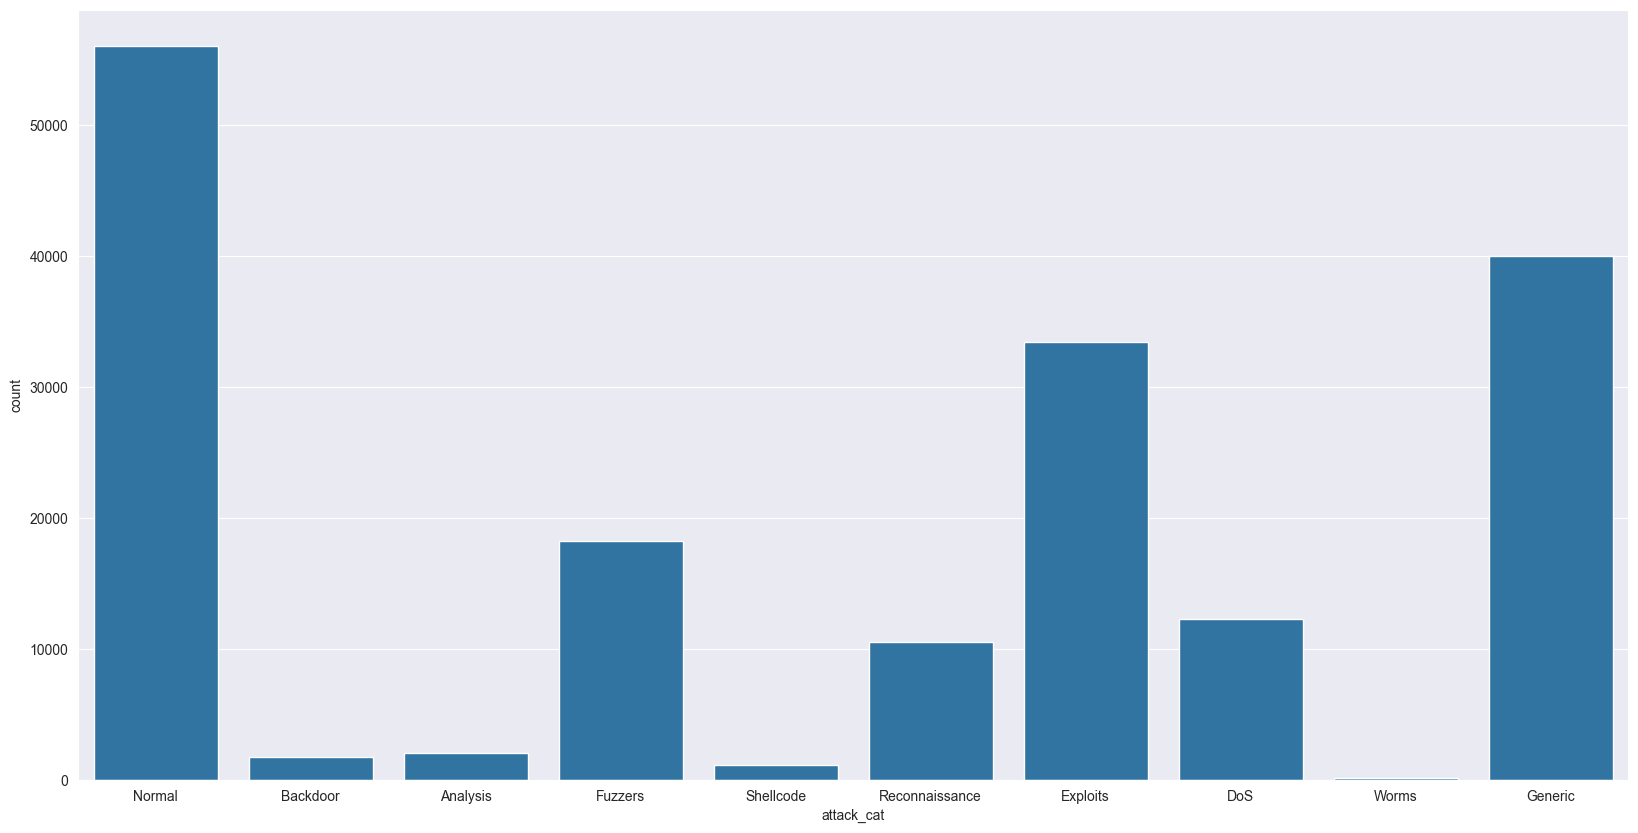

In [68]:
visualize_attack_cats(train_df)

In [69]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [70]:
train_df, dict_values = label_encoder_fit_col(train_df, "proto")
test_df = label_encoder_transform_col(test_df, "proto", dict_values)

In [71]:
train_df, dict_values = label_encoder_fit_col(train_df, "service")
test_df = label_encoder_transform_col(test_df, "service", dict_values)

In [72]:
train_df, dict_values = label_encoder_fit_col(train_df, "state")
test_df = label_encoder_transform_col(test_df, "state", dict_values)

In [73]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [74]:
X_train = train_df.drop(["label", "attack_cat"], axis=1)
y_train = train_df["attack_cat"]
X_test = test_df.drop(["label", "attack_cat"], axis=1)
y_test = test_df["attack_cat"]

In [75]:
X_train = min_max_scaler_fit_col(X_train)
X_test = min_max_scaler_fit_col(X_test)

In [76]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [77]:

class_weights = get_class_weights(y_train)

In [78]:
y_train, cls_label_encoder = label_encode(y_train, len(np.unique(y_train)))
y_test, _ = label_encode(y_test, len(np.unique(y_test)))

In [79]:
cls_label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [80]:
print(y_train.shape)
print(y_test.shape)

(175341, 10)
(82332, 10)


In [81]:
print(X_train.shape)
print(X_test.shape)

(175341, 42, 1)
(82332, 42, 1)


In [82]:
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, GRU
from keras.models import Sequential
def create_LSTM_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [83]:
input_shape = X_train.shape[1:]

In [95]:
lstm_clf = create_LSTM_model(input_shape,10)

In [99]:
from tensorflow.keras.metrics import Recall, Precision
import tensorflow.keras as keras
lstm_clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
                 loss='categorical_crossentropy', metrics=['accuracy', f1_score, Recall(), Precision()])

In [100]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_weights_file_path = "lstm_mul_clf.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy",
                             verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=15)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                              verbose=1, mode='max', min_delta=0.0001, cooldown=0, min_lr=0)

call_backs = [checkpoint, early_stopping, lr_reduce]

In [101]:
lstm_clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 42, 256)           198912    
                                                                 
 dropout_12 (Dropout)        (None, 42, 256)           0         
                                                                 
 batch_normalization_10 (Ba  (None, 42, 256)           1024      
 tchNormalization)                                               
                                                                 
 gru_4 (GRU)                 (None, 42, 128)           148224    
                                                                 
 dropout_13 (Dropout)        (None, 42, 128)           0         
                                                                 
 batch_normalization_11 (Ba  (None, 42, 128)           512       
 tchNormalization)                                    

In [103]:
EPOCHS = 20
BATCH_SIZE = 64
history_clf = lstm_clf.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split=0.2, class_weight=class_weights, callbacks=call_backs)

Epoch 1/20
2192/2192 [==============================] - ETA: 0s - loss: 1.9079 - accuracy: 0.3571 - f1_score: 0.3167 - recall_4: 0.2110 - precision_4: 0.6285
Epoch 1: val_accuracy did not improve from 0.55083
2192/2192 [==============================] - 179s 82ms/step - loss: 1.9079 - accuracy: 0.3571 - f1_score: 0.3167 - recall_4: 0.2110 - precision_4: 0.6285 - val_loss: 1.3411 - val_accuracy: 0.4824 - val_f1_score: 0.4098 - val_recall_4: 0.2617 - val_precision_4: 0.9594 - lr: 0.0050
Epoch 2/20
2191/2192 [============================>.] - ETA: 0s - loss: 1.7977 - accuracy: 0.3771 - f1_score: 0.3478 - recall_4: 0.2346 - precision_4: 0.6639
Epoch 2: val_accuracy did not improve from 0.55083
2192/2192 [==============================] - 186s 85ms/step - loss: 1.7977 - accuracy: 0.3771 - f1_score: 0.3477 - recall_4: 0.2346 - precision_4: 0.6640 - val_loss: 1.5527 - val_accuracy: 0.3883 - val_f1_score: 0.3591 - val_recall_4: 0.2211 - val_precision_4: 0.9750 - lr: 0.0050
Epoch 3/20
2192/2192

In [104]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
def evaluate_Test(model, X_test, y_test, cls_label_encoder):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print_score(y_hat, y_true, cls_label_encoder)

In [105]:
def visualize_loss(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [106]:
def visualize_accuracy(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [107]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_hat)
    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=cls_label_encoder.classes_, yticklabels=cls_label_encoder.classes_)
    plt.show()

In [118]:
evaluate_Test(lstm_clf, X_test, y_test, cls_label_encoder)

2573/2573 [==============================] - 43s 17ms/step
Accuracy:  0.60302241232321
Precision Score:  0.724923545125
Recall Score:  0.56521623426226
F1 Score:  0.6320623263526
Confusion Matrix
[[    0     0   609     0    55     0     2     8     3     0]
 [    0     4   504     0    10     0     2    46     6    11]
 [    3    15  2714     1    99     4     5   411   131   706]
 [   47    25  2950     0   384     9    25  1961   691  5040]
 [   45    13  1184     1  2442    41   600   937   388   411]
 [  793     1    41     0    36 16805    62   283    46   804]
 [ 1154    75     6     0 11484    76  7796  6163  2022  8224]
 [    4     8   293     0   187     1    14  2242   248   499]
 [    0     0     0     0    32     0     0   311    35     0]
 [    0     0     0     0     1     0     0     8     1    34]]


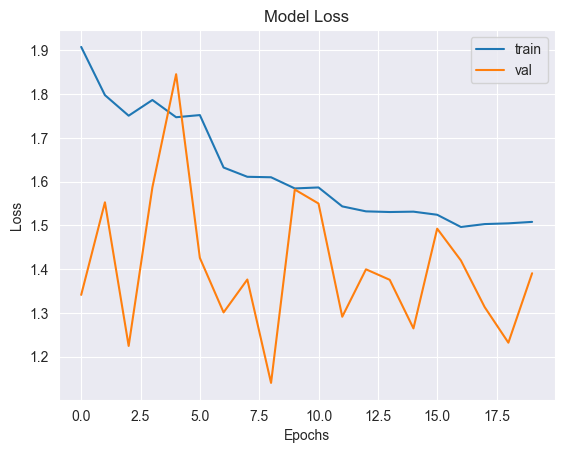

In [114]:
visualize_loss(history_clf)

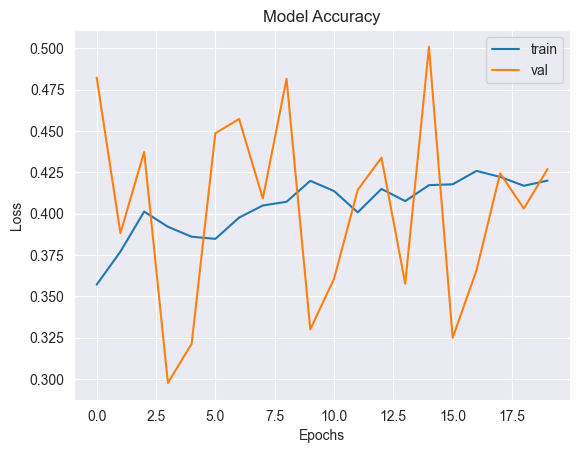

In [115]:
visualize_accuracy(history_clf)

2573/2573 [==============================] - 42s 16ms/step


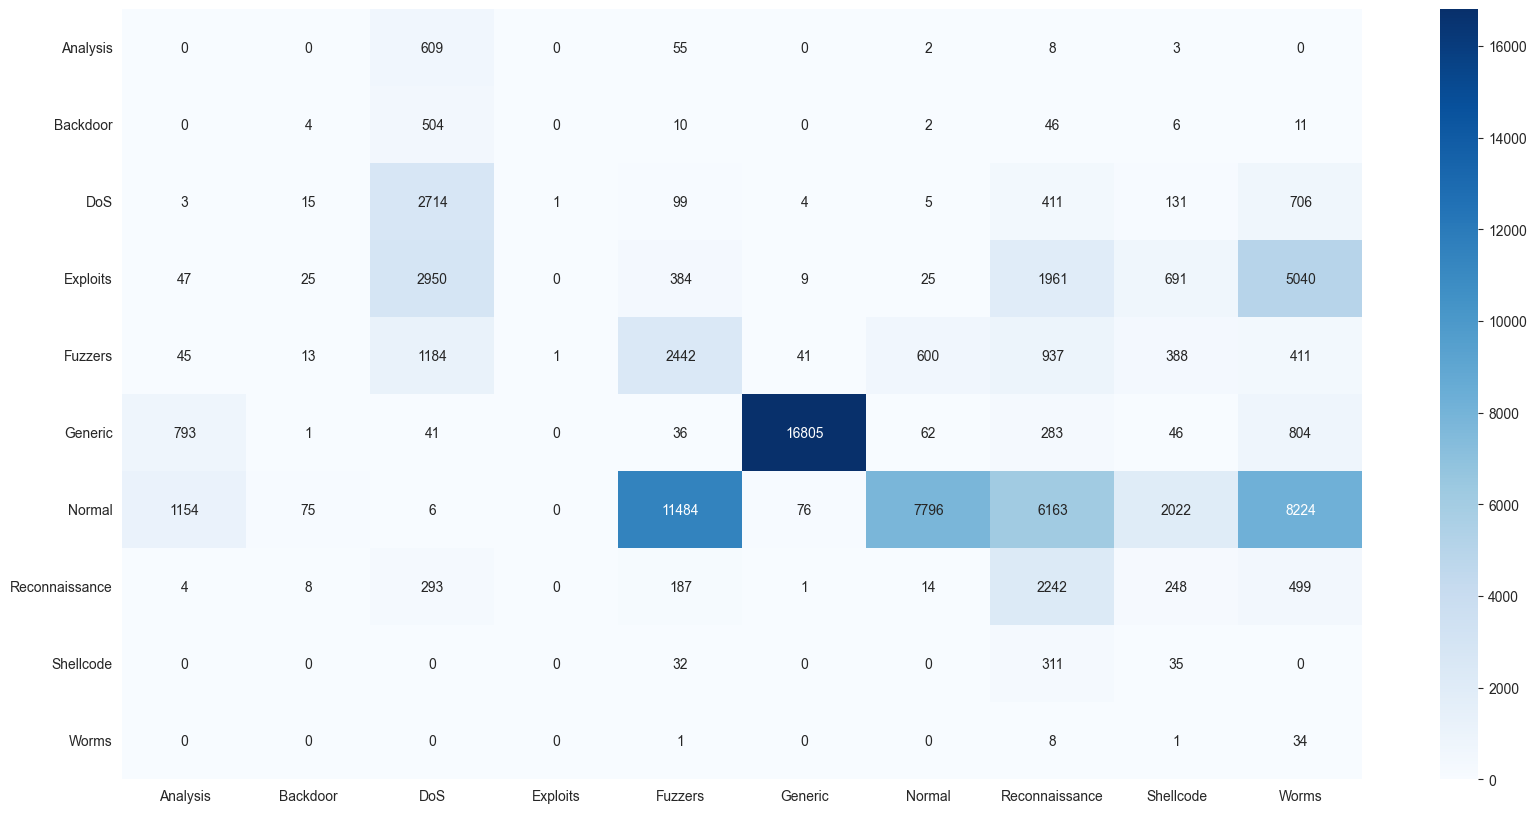

In [116]:
plot_confusion_matrix(lstm_clf, X_test, y_test)